<a href="https://colab.research.google.com/github/emmad225/BIACoursework/blob/main/duffyep_lab3_image_registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [CSCI 3397/PSYC 3317] Lab 3: Image Registration

**Posted:** Monday, February 12, 2023

**Due:** Monday, February 19, 2023

__Total Points__: 8 pts

__Submission__: please rename the .ipynb file as __\<your_username\>_lab3.ipynb__ before you submit it to canvas. Example: weidf_lab3.ipynb.

In [ ]:
# download image
! wget https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-01.ome.tiff -O exemplar-001-cycle-01.ome.tiff
! wget https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-03.ome.tiff -O exemplar-001-cycle-03.ome.tiff
! wget https://bc-cv.github.io/csci3397/public/dip_registration/view_1.jpg -O view_1.jpg
! wget https://bc-cv.github.io/csci3397/public/dip_registration/view_2.jpg -O view_2.jpg

--2024-02-20 01:15:55--  https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-01.ome.tiff
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66638807 (64M) [image/tiff]
Saving to: ‘exemplar-001-cycle-01.ome.tiff’

exemplar-001-cycle- 100%[===================>]  63.55M   260MB/s    in 0.2s    

2024-02-20 01:15:58 (260 MB/s) - ‘exemplar-001-cycle-01.ome.tiff’ saved [66638807/66638807]

--2024-02-20 01:15:58--  https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-03.ome.tiff
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66638603 (64M) [image/tiff]
Saving to: ‘exempla

In [ ]:
# auxilary functions for visualization
import numpy as np
from PIL import Image
from IPython.display import Image as Image_dsp
import matplotlib.pyplot as plt
from imageio import imread


def plotImgPair(img1, img2, cm = 'gray', title=['','']):
    fig, ax = plt.subplots(1, 2, figsize=(15, 20))
    for i,a in enumerate(ax):
        a.set_axis_off()
        if title[i] != '':
            a.set_title(title[i])
    ax[0].imshow(img1, cmap=cm)
    ax[1].imshow(img2, cmap=cm)

def autoContrast(I, thres=[1,99]):
    # compute percentile: remove too big or too small values
    I_low, I_high = np.percentile(I.reshape(-1), thres)
    # thresholding
    I[I > I_high] = I_high
    I[I < I_low] = I_low
    # scale to 0-1
    I = (I.astype(float)- I_low)/ (I_high-I_low)
    # convert it to uint8
    I = (I * 255).astype(np.uint8)
    return I

def dispGif(img1, img2, filename='tmp.gif'):
    im1 =  Image.fromarray(img1)
    im2 =  Image.fromarray(img2)
    im1.save(filename, format='GIF',
                   append_images=[im2],
                   save_all=True,
                   duration=300, loop=0)
    return Image_dsp(open(filename,'rb').read())


# <b>1. Image Transformation (Lec. 9)</b>

## 1.1 Visualize image pairs

Lec. 9, Page 8-9

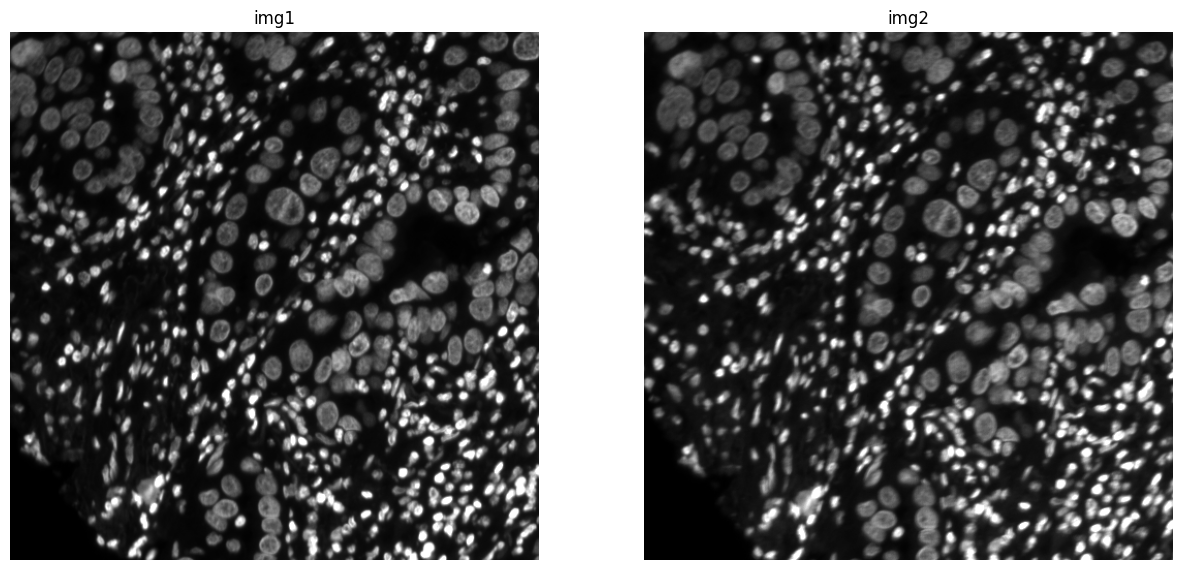

In [ ]:
from imageio import volread
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

# "imAdjust()" defined in auxilary functions
img1 = autoContrast(volread('exemplar-001-cycle-01.ome.tiff')[0,:512,:512])
img2 = autoContrast(volread('exemplar-001-cycle-03.ome.tiff')[0,:512,:512])

# "plotImgPair()" defined in auxilary functions
# hard to tell the difference
plotImgPair(img1, img2, title=['img1', 'img2'])

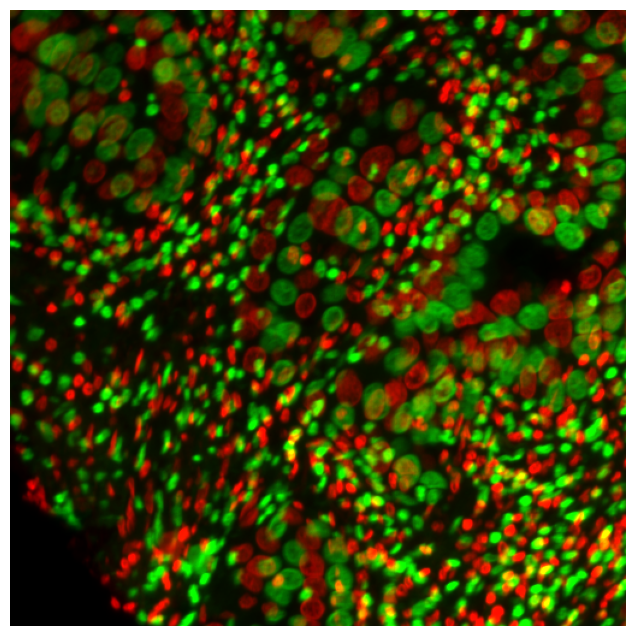

In [ ]:
# RGB visualization
sz = img1.shape
out = np.zeros([sz[0], sz[1], 3], np.uint8)
out[:,:, 0] = img1
out[:,:, 1] = img2

plt.figure(figsize=(8, 8))
plt.imshow(out);plt.axis('off')
plt.show()

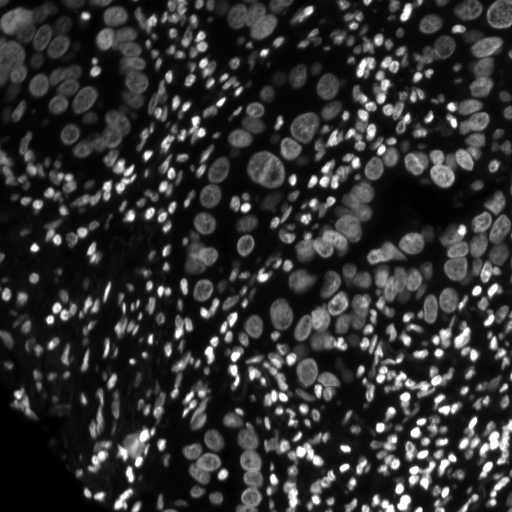

In [ ]:
# GIF visualization
dispGif(img1, img2)

## 1.2 Point cloud representation

Lec. 9, Page 12

In [ ]:
import numpy as np

im_size = [3,3]
I = 100 * np.arange(np.prod(im_size)).reshape(im_size)

print('Matrix representation:\n', I)

[x,y] = np.meshgrid(np.arange(im_size[0]), np.arange(im_size[1]))

print('------------')
print('Point cloud representation (x,y,I):')
print(np.hstack([x.reshape(-1,1),y.reshape(-1,1),I.reshape(-1,1)]))

Matrix representation:
 [[  0 100 200]
 [300 400 500]
 [600 700 800]]
------------
Point cloud representation (x,y,I):
[[  0   0   0]
 [  1   0 100]
 [  2   0 200]
 [  0   1 300]
 [  1   1 400]
 [  2   1 500]
 [  0   2 600]
 [  1   2 700]
 [  2   2 800]]


## 1.3 Transformation
The benefit of forward warping is that it's straightforward to visualize what happens to the pixels.

Lec. 9, Page 15-17

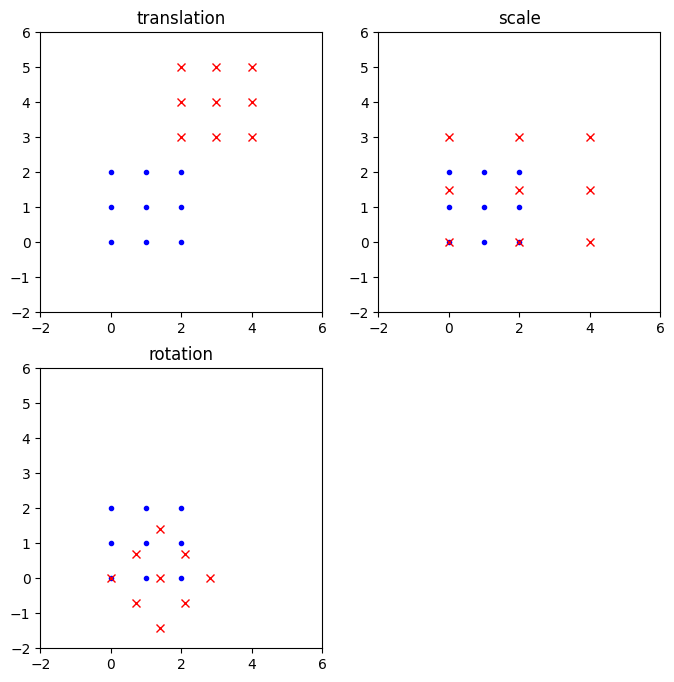

In [ ]:
import matplotlib.pyplot as plt

T_trans = np.array([[1,0,2],[0,1,3]])
T_scale = np.array([[2,0,0],[0,1.5,0]])
theta= 45/180*np.pi
T_rotate = np.array([[np.cos(theta),np.sin(theta),0],\
                     [-np.sin(theta),np.cos(theta),0]])


T=[T_trans, T_scale, T_rotate]
names=['translation','scale','rotation']

pos = np.vstack([x.reshape(-1), y.reshape(-1), np.ones(y.size)])

plt.figure(figsize=(8, 8))

for i,t in enumerate(T):
    plt.subplot(2,2,i+1)
    plt.plot(x.reshape(-1), y.reshape(-1),'b.')
    # numpy matrix multiplication
    pos2 = np.matmul(t, pos)
    plt.plot(pos2[0], pos2[1],'rx')
    plt.xlim([-2,6])
    plt.ylim([-2,6])
    plt.title(names[i])

# <b>2. Transformation estimation (Lec. 10-11) </b>

## 2.1 Template matching

Lec. 10, page 18-20

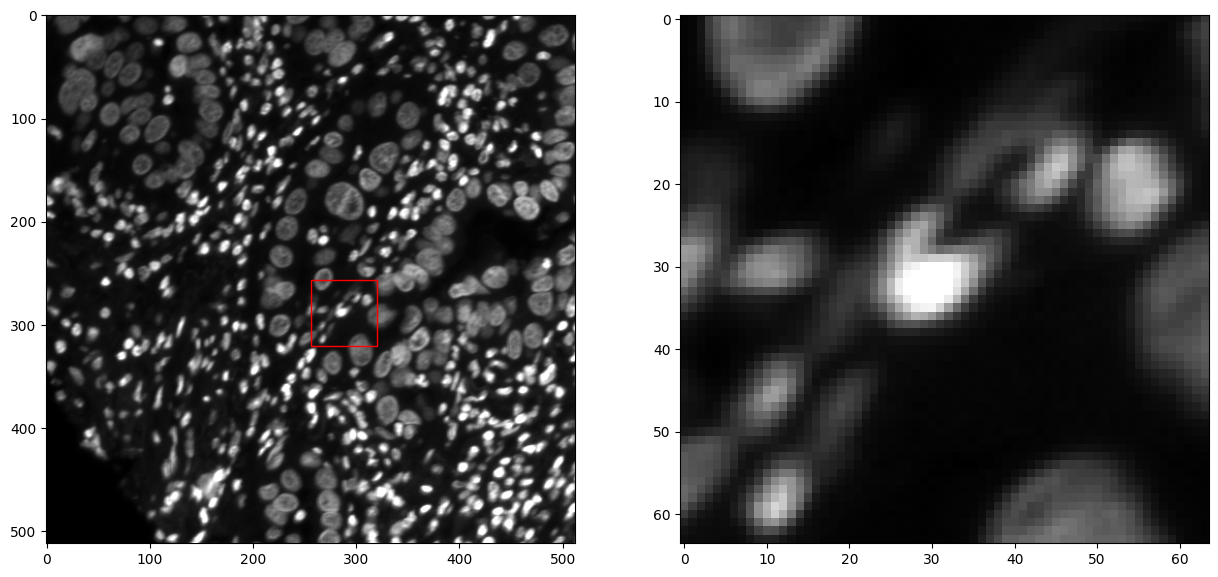

In [ ]:
import cv2

crop_start = [256,256]
crop_size = [64,64]
img2_template = img2[crop_start[0] : crop_start[0] + crop_size[0],\
                    crop_start[1] : crop_start[1] + crop_size[1]]


fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15, 20))
ax1.imshow(img2, cmap='gray')
rect = plt.Rectangle((crop_start[0], crop_start[1]), crop_size[0], crop_size[1], edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax2.imshow(img2_template, cmap='gray')


### (a) Cross-correlation
(same as convolution, except no flipping kernel)

<img src="https://docs.opencv.org/2.4/_images/math/93f1747a86a3c5095a0e6a187442c6e2a0ae0968.png">

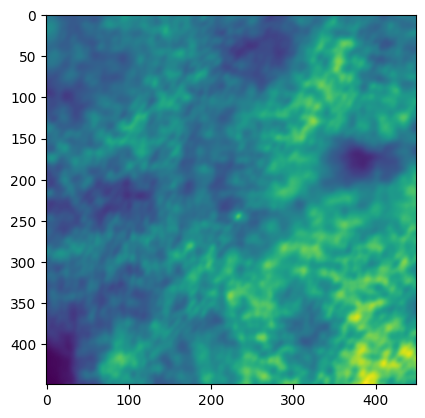

In [ ]:
# the maximum location is at the bottom-right border
# the result won't be bad if we increase the crop size
heatmap_cc = cv2.matchTemplate(img1, img2_template, cv2.TM_CCORR)
plt.imshow(heatmap_cc)

### (b) Normalized Cross-correlation
For each patch, divide the correlations result by the norm of both patches.

<img src="https://docs.opencv.org/2.4/_images/math/6a72ad9ae17c4dad88e33ed16308fc1cfba549b8.png">

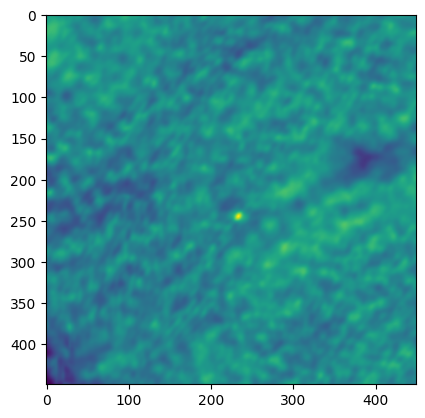

In [ ]:
# now the maximum
heatmap_ncc = cv2.matchTemplate(img1, img2_template, cv2.TM_CCORR_NORMED)
plt.imshow(heatmap_ncc)

### (c) Visualize the result

shift by: (-23,-11)


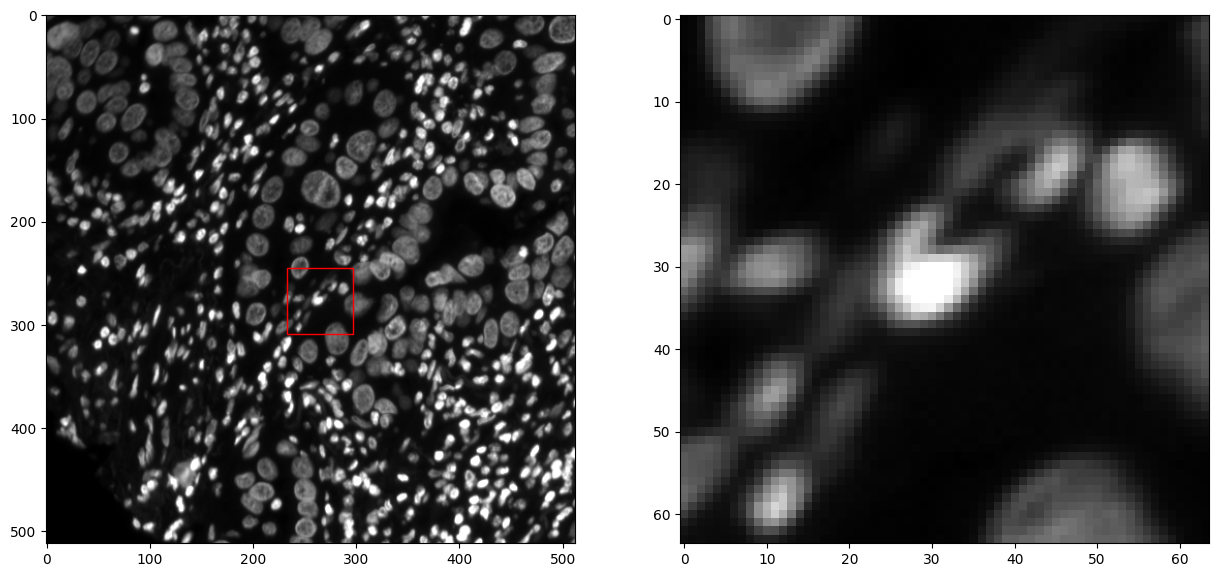

In [ ]:
ij = np.unravel_index(np.argmax(heatmap_ncc), heatmap_ncc.shape)
match_x, match_y = ij[::-1]

print('shift by: (%d,%d)' % (match_x-crop_start[0], match_y-crop_start[1]))

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15, 20))
ax1.imshow(img1, cmap='gray')
rect = plt.Rectangle((match_x, match_y), crop_size[0], crop_size[1], edgecolor='r', facecolor='none')
ax1.add_patch(rect)

ax2.imshow(img2_template, cmap='gray')

### (d) Warp img2

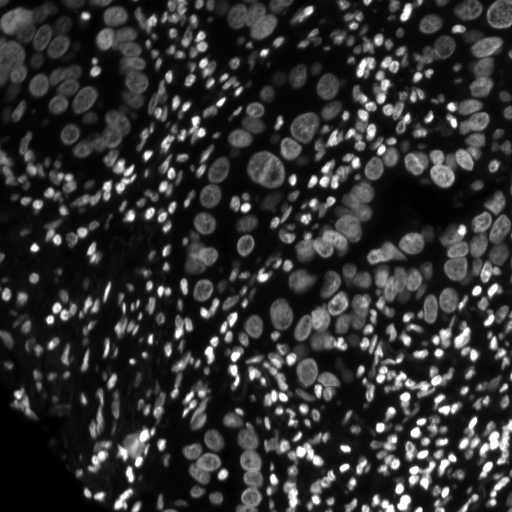

In [ ]:
A = np.ones([2,3])
A[1,0] = 0
A[0,1] = 0
A[0,2] = -crop_start[0] + match_x
A[1,2] = -crop_start[1] + match_y

img2_trans = cv2.warpAffine(img2, A, img1.shape)

dispGif(img1, img2_trans)

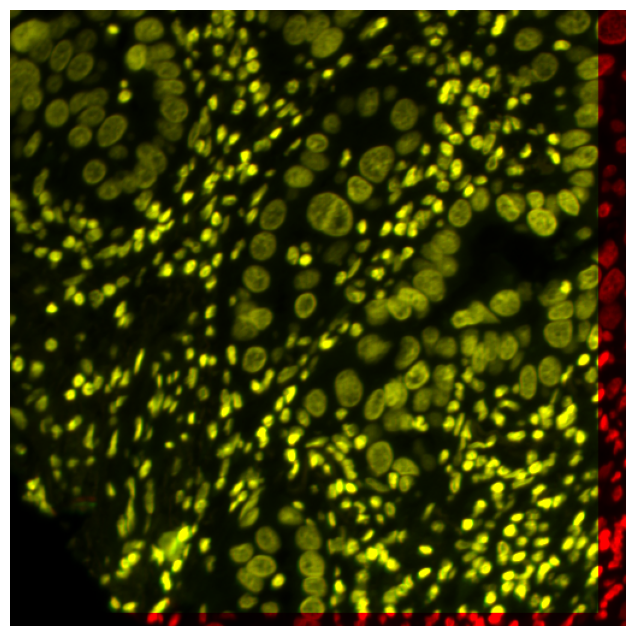

In [ ]:
# Note that the rgb visualization is not as sensitive to show the error
out = np.zeros([img1.shape[0], img1.shape[1], 3], np.uint8)
out[:,:, 0] = img1
out[:,:, 1] = img2_trans

plt.figure(figsize=(8, 8))
plt.imshow(out);plt.axis('off')
plt.show()

## 2.2 3-Step Pipeline

Lec. 11

### (a) Step 1. Get the key points

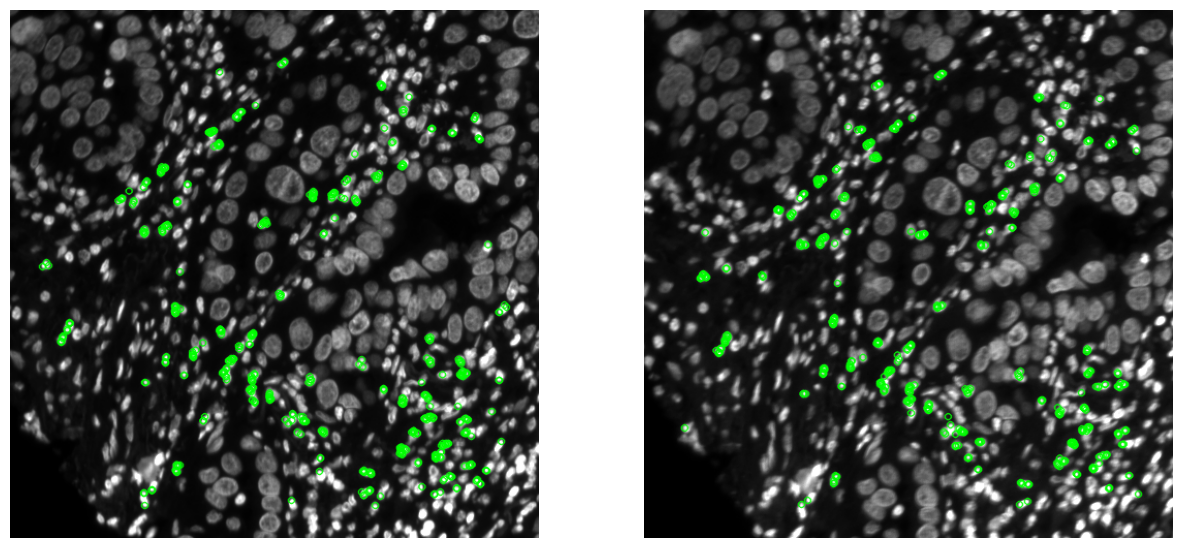

In [ ]:
import cv2
def get_orb_features(img):
    '''
    Compute ORB features using cv2 library functions (hint: you will need cv2.ORB_create() and some related functions).  Use default parameters when computing the keypoints.
    Input:
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of ORB descriptors
    '''
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return keypoints, descriptors


kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

plotImgPair(kp_img1, kp_img2)

### (b) Step 2. Find matches among key points

orb feature matches


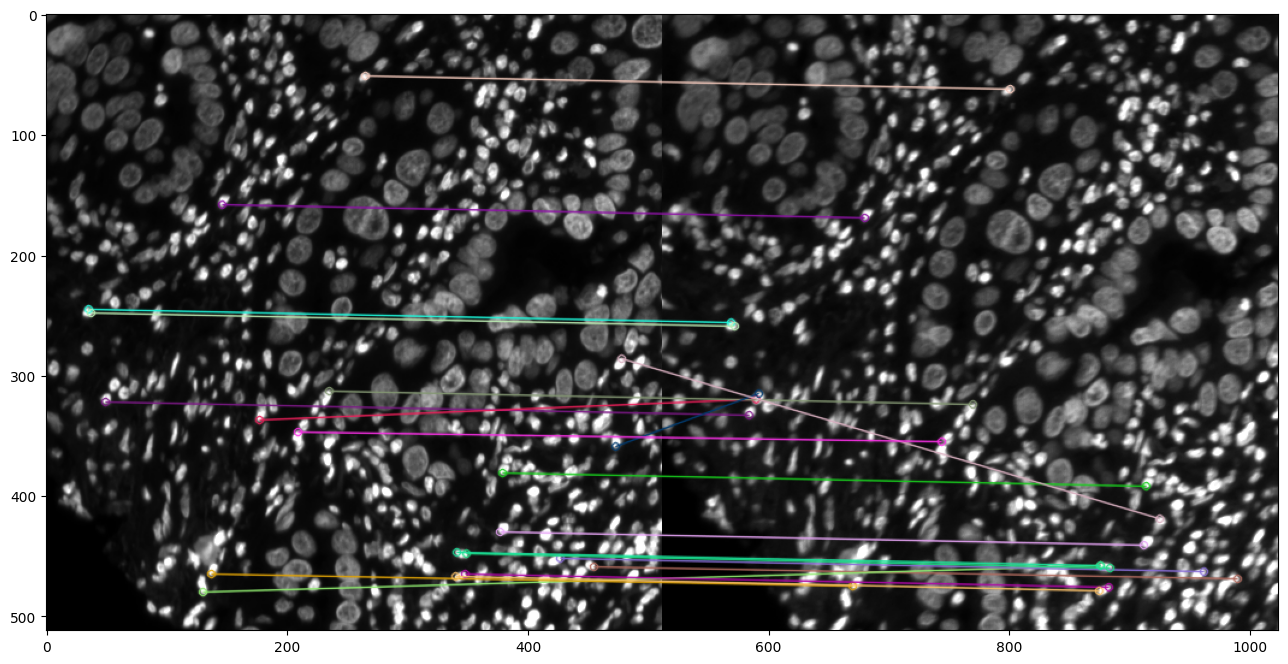

In [ ]:
def match_keypoints(desc_1, desc_2):
    '''
    Compute matches between feature descriptors of two images using ratio test.
    You may use cv2 library functions.(hint: you may need to use cv2.DescriptorMatcher_create or cv2.BFMatcher and some related functions)
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
    '''
    matcher = cv2.DescriptorMatcher_create("BruteForce-Hamming")
    matches = matcher.match(desc_1, desc_2)
    return matches

# display the top-20 matches
# note that some matches are quite off (e.g., big tree branches in the left image)
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("orb feature matches")

plt.figure(figsize=(16, 8))
plt.imshow(match_plot)

### (c) Step 3. Estimate transformation

In [ ]:
pts_1 = np.vstack([kp_1[m.queryIdx].pt for m in matches])
pts_2 = np.vstack([kp_2[m.trainIdx].pt for m in matches])

T_aff, status = cv2.estimateAffine2D(pts_2, pts_1, cv2.RANSAC)

print(T_aff)
print('Number of input pairs: %d\nNumber of matched pairs: %d' % (len(status), status.sum()))

[[ 1.00048466e+00 -9.56722061e-04 -2.26707889e+01]
 [ 2.40411759e-04  1.00369662e+00 -1.22286537e+01]]
Number of input pairs: 500
Number of matched pairs: 334


## 2.3 [Demo] Panoroma stitching

Organize the code in section 2.2 into one function

In [ ]:
def panoramic_stitching(img1, img2, do_display=True):
  '''
    Given a pair of overlapping images, generate a panoramic image.
    Hint: use the functions that you've written in the previous parts.
    Input:
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  # 1.detect keypoints and extract orb feature descriptors
  kp_1, desc_1 = get_orb_features(img1)
  kp_2, desc_2 = get_orb_features(img2)

  # 2.match features between two images
  matches = match_keypoints(desc_1, desc_2)
  pts_2 = np.vstack([kp_2[m.trainIdx].pt for m in matches])
  pts_1 = np.vstack([kp_1[m.queryIdx].pt for m in matches])


  # 3.compute homography matrix H transforming points from pts_2 to pts_1. Note the order here (not pts_1 to pts_2)!
  T_aff, status = cv2.estimateAffine2D(pts_2, pts_1, cv2.RANSAC)

  # 4. apply perspective wrap to stitch images together
  # use img1 as the canvas
  # rough approximation of the output image size
  output_size = (img2.shape[1] + img1.shape[1], img2.shape[0] + img1.shape[0])

  # warp img2 with H
  final_img = cv2.warpAffine(img2, T_aff, output_size)

  # copy img1 to the final image
  # pixels in img1 remain in the same position in the original position
  final_img[0:img1.shape[0], 0:img1.shape[1]] = img1

  # crop the empty region
  col_sum = final_img.max(axis=0)
  row_sum = final_img.max(axis=1)
  last_col = np.where(col_sum!=0)[0][-1]
  last_row = np.where(row_sum!=0)[0][-1]

  final_img = final_img[:last_row, :last_col]

  if do_display:
    plt.figure(figsize=(16, 8))
    plt.imshow(final_img)
    plt.show()

  return final_img

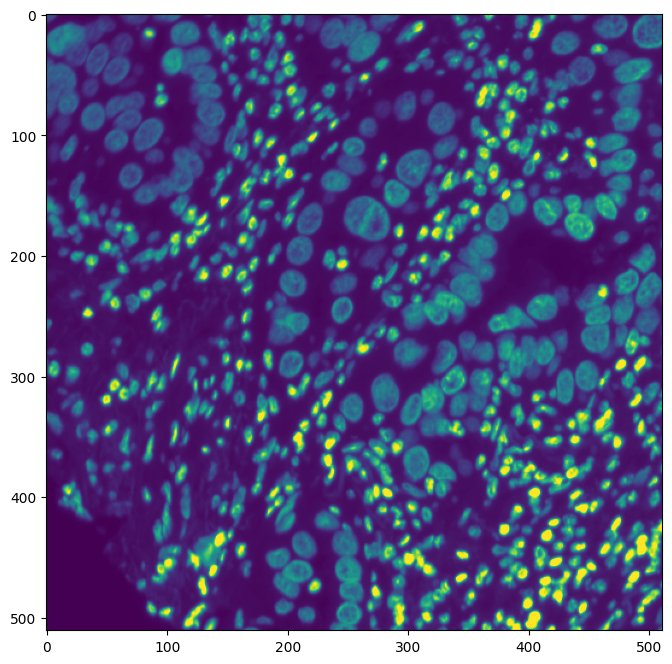

In [ ]:
# Align the two images above
result = panoramic_stitching(img1, img2)

<ipython-input-19-89963882974a>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plotImgPair(imread('view_1.jpg'), imread('view_2.jpg'))


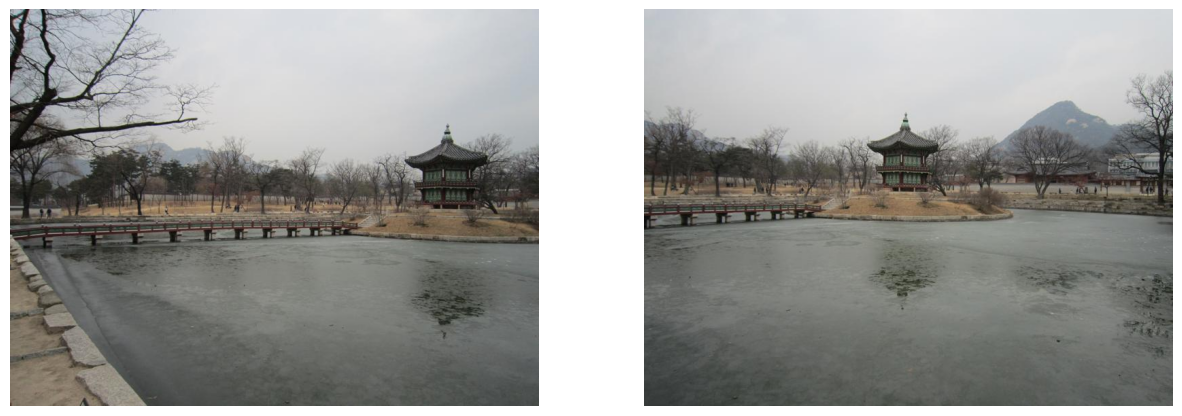

In [ ]:
# Let's look at some natural images that are not a simple shift
plotImgPair(imread('view_1.jpg'), imread('view_2.jpg'))

<ipython-input-20-839bfb6d53e6>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  result = panoramic_stitching(imread('view_1.jpg'), imread('view_2.jpg'))


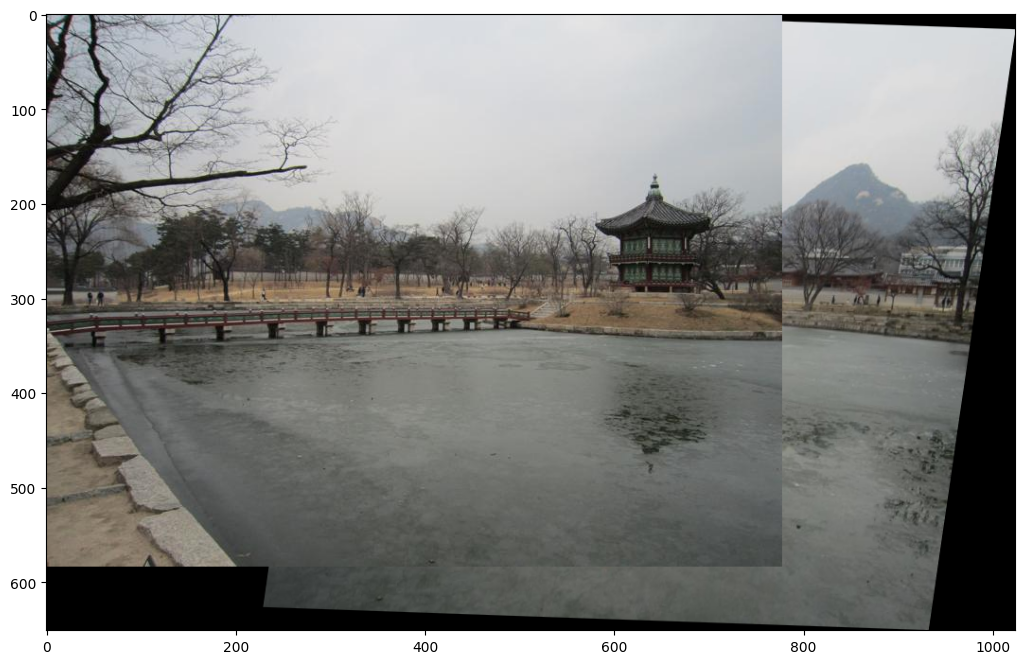

In [ ]:
result = panoramic_stitching(imread('view_1.jpg'), imread('view_2.jpg'))

# [8 pts] Exercise
As pset1 is out, we'll make this lab light-weight :)

## (1) [2 pts] Visualize an affine transformation

In sec. 1.2, we showed how to plot the forward warping with translation, scale, and rotation. Here, write down an arbitrary affine transformation matrix and transform the points.

Lec. 6, page 18

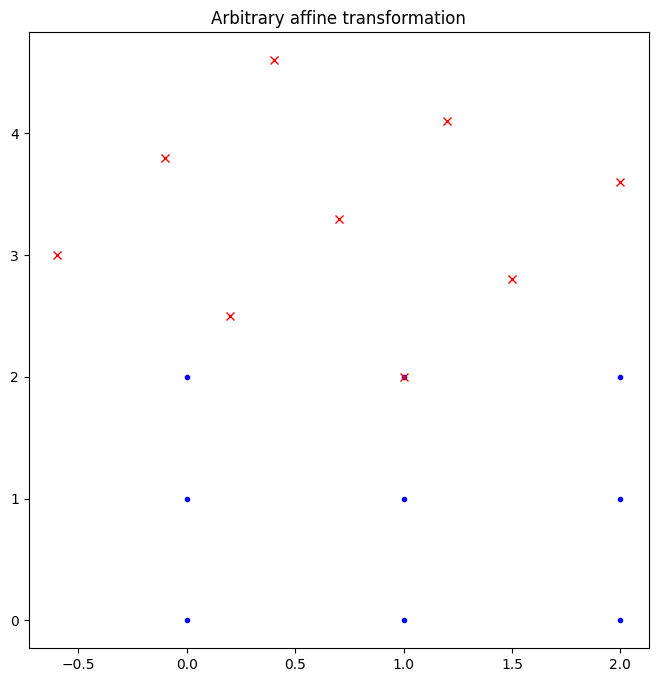

In [ ]:
# make image (dots) to test on
import numpy as np
import matplotlib.pyplot as plt

im_size = [3,3]
I = 100 * np.arange(np.prod(im_size)).reshape(im_size)
[x,y] = np.meshgrid(np.arange(im_size[0]), np.arange(im_size[1]))
pos = np.vstack([x.reshape(-1), y.reshape(-1), np.ones(y.size)])

plt.figure(figsize=(8, 8))
plt.plot(x.reshape(-1), y.reshape(-1),'b.')

### Your code starts here
T_affine = np.array([[0.5, -0.8, 1],
                          [0.8, 0.5, 2],
                          [0, 0, 1]])

# transform pos
pos2 =  np.dot(T_affine, pos)
### Your code ends here

plt.plot(pos2[0], pos2[1],'rx')
plt.title('Arbitrary affine transformation')
plt.show()


## (2) [2 pts] Bilinear interpolation

Lec. 10, page 12

In [ ]:
def bilinearInterp(mat, pos):
    # mat: [[I0,I1],[I2,I3]], 2x2 numpy matrix with values at four corners
    # pos: (\alpha, \beta), numpy array for the position
    val = 0
    alpha, beta = pos
    ### Your code starts here

    # Four corner values
    I0, I1 = mat[0, 0], mat[0, 1]
    I2, I3 = mat[1, 0], mat[1, 1]

    val = (1 - alpha) * ((1 - beta) * I0 + beta * I2) + alpha * ((1 - beta) * I1 + beta * I3)

    ### Your code ends here
    return val

## test case

test_mat = np.array([[50,100],[150,200]])
test_pos = [0.7, 0.3]

print(bilinearInterp(test_mat, test_pos))

115.0


## (3) [4 pts] Visualize Sec. 2.2 results

- Run through sec. 2.2 to get affine transformation of img2
- Visualize both the RGB and Gif results here.

The example here is simple and the simple translation works similarly to affine transformation.

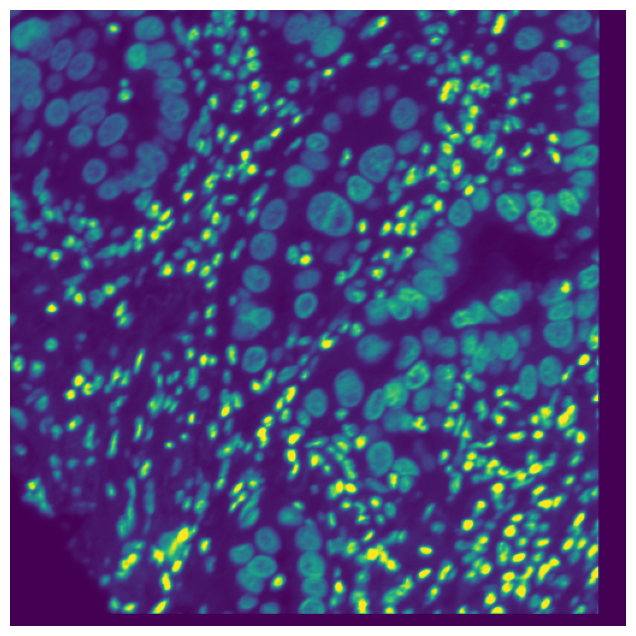

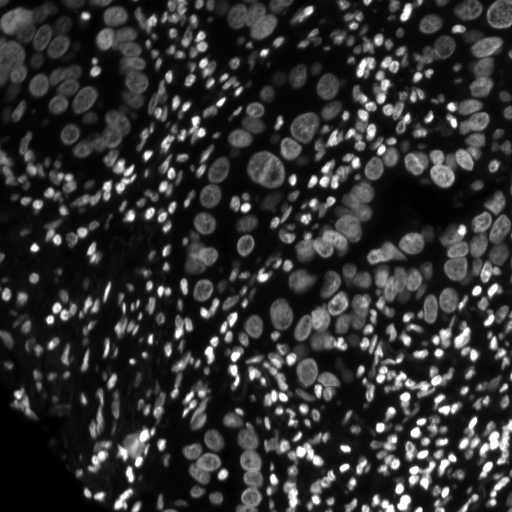

In [ ]:
### Your code starts
# [1 pt]
img2_trans_aff = cv2.warpAffine(img2, T_aff, (img2.shape[1], img2.shape[0]))

# 1. [2 pts] RGB visualization of results
out = img2_trans_aff

plt.figure(figsize=(8, 8))
plt.imshow(out);plt.axis('off')
plt.show();

# 2. [1 pt] gif visualization of results
dispGif(img1, out)